# Classifying Email Domains

This notebook explores the possibility of classifying email domains based on the characteristics of their activity distribution.

In [1]:
from bigbang.archive import Archive
from bigbang.config import CONFIG
import bigbang.datasets.domains as domains
import bigbang.analysis.utils as utils
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [2]:
import powerlaw

# Domain categories

This is data about known domain categories.

 * **Generic hosts**. Generic providers of email addresses. See https://github.com/edwin-zvs/email-providers
 * **Personal**. Email domains set up for use by an individual or a very small company.
 * **Companies**. An email domain used by the employees of a large corporation.
 * **Internet Governance**. Email domains associated with an Internet Governance body.
 * **Academia**. Email domains associated with an university, research lab, or professional research organization.

In [3]:
dc = domains.load_data()

# Working with the data

## Load IETF archive data

We start by loading the IETF archive data.

In [4]:
number = r"^[0-9]"

In [5]:
arxs = {}

for file in os.listdir(CONFIG.mail_path):
    if file.endswith(".csv") and not re.match(number, file):
        name = file[:-4]
        try:
            arxs[name] = Archive(name)
        except Exception as e:
            print(name + ": " + str(e))

dasl: 'Archive after initial processing is empty. Was data collected properly?'
deltav: 'Archive after initial processing is empty. Was data collected properly?'
aulli: 'Archive after initial processing is empty. Was data collected properly?'
carddav: 'Archive after initial processing is empty. Was data collected properly?'
email-notifications: 'Archive after initial processing is empty. Was data collected properly?'
fyiup: 'Archive after initial processing is empty. Was data collected properly?'
CCAMP: 'Archive after initial processing is empty. Was data collected properly?'
dlswmib: 'Archive after initial processing is empty. Was data collected properly?'
enroll: 'Archive after initial processing is empty. Was data collected properly?'
smime: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

dea-dir: 'Archive after initial processing is empty. Was data collected properly?'
iab-wireless-workshop: 'Archive after initial processing is empty. Was da

In [6]:
print("Total number of Archives: " + str(len(arxs)))

Total number of Archives: 300


## Combine email data

Collect information about the senders from each mailing list.

In [7]:
def senders(arx):
    emails = arx.data["From"].apply(utils.extract_email)
    domains = arx.data["From"].apply(utils.extract_domain)
    froms = pd.concat(
        [arx.data["From"], emails, domains], axis=1, keys=["From", "email", "domain"]
    )

    return froms

In [8]:
wg_senders = {wg: senders(arxs[wg]) for wg in arxs}

## Explore the data

We are going to start with using statistics from the global corpus of data. To combine the data from each working group into one DataFrame.

In [9]:
def add_wg_row(df, wg):
    df2 = df.copy()
    df2["wg"] = wg

    return df2


all_senders = pd.concat([add_wg_row(wg_senders[wg], wg) for wg in wg_senders])

Each email domain participates in some number of working groups. It also contains some number of unique email addresses. Just to get a sense of the variety, we will look at and compare these two distributions.

<AxesSubplot:xlabel='domain'>

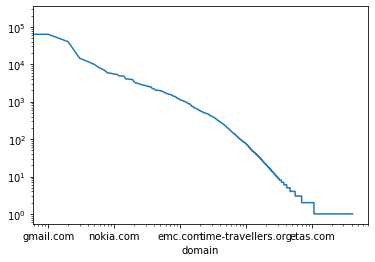

In [10]:
all_senders.groupby("domain").size().sort_values(ascending=False).plot(loglog=True)

In [11]:
data = all_senders.groupby("domain").size().values  # data can be list or numpy array
results = powerlaw.Fit(data)
print(results.power_law.alpha)
print(results.power_law.xmin)

R, p = results.distribution_compare("power_law", "lognormal", normalized_ratio=True)
print(R, p)

Calculating best minimal value for power law fit
1.6291030106704891
5.0
-2.305360041754689 0.021146417430933855


<AxesSubplot:xlabel='wg'>

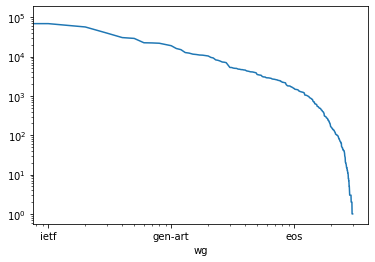

In [12]:
all_senders.groupby("wg").size().sort_values(ascending=False).plot(loglog=True)

In [13]:
data = all_senders.groupby("wg").size().values  # data can be list or numpy array
results = powerlaw.Fit(data)
print(results.power_law.alpha)
print(results.power_law.xmin)

R, p = results.distribution_compare("power_law", "lognormal", normalized_ratio=True)
print(R, p)

Calculating best minimal value for power law fit
2.050454925027005
2158.0
-0.5063114543174063 0.6126380232284334


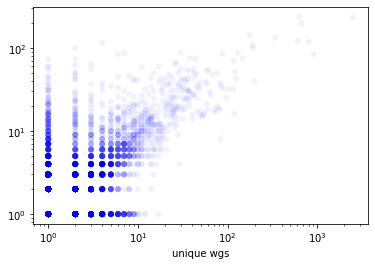

In [14]:
x = all_senders.groupby("domain")["email"].unique().apply(len)
y = all_senders.groupby("domain")["wg"].unique().apply(len)

import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.gca()
ax.scatter(x, y, c="blue", alpha=0.05, edgecolors="none")
ax.set_xlabel("unique emails")
ax.set_xlabel("unique wgs")
ax.set_yscale("log")
ax.set_xscale("log")

## Compute more domain statistics

We will now compute more summary statistics for each domain.

In [15]:
domain_unique_emails = all_senders.groupby("domain")["email"].apply(
    lambda g: np.log1p(g.unique().size)
)
domain_unique_wgs = all_senders.groupby("domain")["wg"].apply(
    lambda g: np.log1p(g.unique().size)
)
domain_unique_wgs

domain
------------.dsi.unifi.it.cnri.reston.va.us    0.693147
0-0.com                                        1.098612
001sm.com                                      0.693147
002ranch.com                                   0.693147
004.com                                        0.693147
                                                 ...   
zzd.download                                   0.693147
zzddc.com                                      0.693147
zzei.accountant                                0.693147
zzworld.gdn                                    0.693147
zzz.com                                        0.693147
Name: wg, Length: 41334, dtype: float64

In [16]:
domain_means = all_senders.groupby("domain")["email"].apply(
    lambda g: g.value_counts().mean()
)
domain_stds = all_senders.groupby("domain")["email"].apply(
    lambda g: g.value_counts().std()
)
domain_means_log = np.log1p(domain_means)
domain_medians = all_senders.groupby("domain")["email"].apply(
    lambda g: g.value_counts().median()
)
domain_medians_log = np.log1p(domain_medians)
domain_max = all_senders.groupby("domain")["email"].apply(
    lambda g: g.value_counts().max()
)
domain_max_log = np.log1p(domain_max)

In [17]:
df = pd.DataFrame(
    data={
        "n_e": domain_unique_emails,
        "n_w": domain_unique_wgs,
        "log_mean": domain_means_log,
        "log_median": domain_medians_log,
        "log_max": domain_max_log,
        "nstd": domain_stds.fillna(0) / domain_means,
    }
)

In [18]:
dc["category"].at["gmail.com"]

'generic'

And add the category labels if known.

In [19]:
def categorize_domain(d):
    try:
        return dc["category"].at["gmail.com"]
    except Exception as e:
        return None


labels = pd.Series(data=df.index, index=df.index).apply(categorize_domain)

df["labels"] = labels

A little data cleaning....

In [20]:
df = df[df["log_mean"] > 0.0]

In [21]:
df.head()

,n_e,n_w,log_mean,log_median,log_max,nstd,labels
domain,,,,,,,
------------.dsi.unifi.it.cnri.reston.va.us,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,generic
0-0.com,0.693147,1.098612,1.609438,1.609438,1.609438,0.0,generic
001sm.com,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,generic
002ranch.com,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,generic
004.com,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,generic


generic
personal
company
academic
sdo


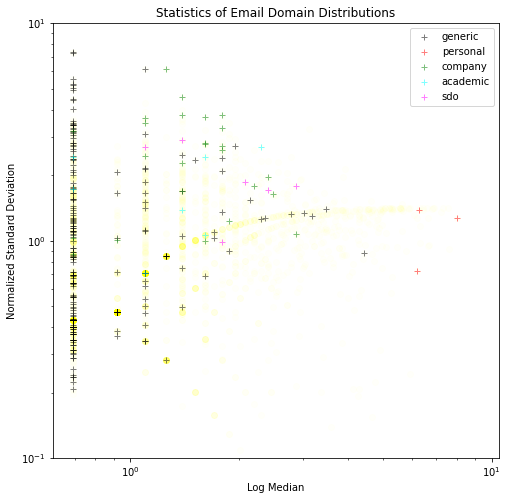

In [22]:
fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.plot(df["log_median"], df["nstd"], "o", c="yellow", alpha=0.02)

colors = ["black", "red", "green", "cyan", "magenta"]

for i, group in enumerate(dc["category"].unique()):
    print(group)
    group_idx = set(df.index).intersection(set(dc[dc["category"] == group].index))
    gdf = df.loc[group_idx, :]
    ax.plot(gdf["log_median"], gdf["nstd"], "+", c=colors[i], alpha=0.5, label=group)

ax.set_xlabel("Log Median")
ax.set_ylabel("Normalized Standard Deviation")
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_title("Statistics of Email Domain Distributions")

ax.set_ylim([0.1, 10])

ax.legend()

There is some evidence to say that different categories of email domains are distinguishable based on properties of their email distributions. 

A next step is to build and test and automated classifier and test the results.